# TD8 - Non-local means

In this TD, we explore a well-known method for inpainting. 
This method is called non-local means and use the redundant information to denoise or perform the inpainting. The proposed implementation is however far from being state of the art.

In [2]:
from __future__ import division
import imageio
%pylab inline
import numpy as np
import scipy as sp
import scipy.fftpack as ft

Populating the interactive namespace from numpy and matplotlib


(633, 950, 3)
136.38214111328125 56.72638572832264 0.0
(128, 128)


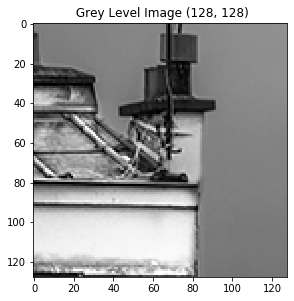

In [3]:
# load an image
import imageio as imio
colored_image = imio.imread('toits.jpg')
print(colored_image.shape)
n = colored_image.shape[0]-1
n = 128
image = np.sum(colored_image*[0.21, 0.72 ,0.07],axis=-1)[n:2*n,100:100+n]

plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.gray()
#cropped = image[n:n+64,n:n + 64]
plt.title(" Grey Level Image " + str(np.shape(image)))
cropped = image
plt.imshow(image)
print(np.mean(cropped),np.std(cropped),(np.min(cropped)))
print(image.shape)
image0 = np.copy(image)

We define the snr and several types of noise.

-0.0


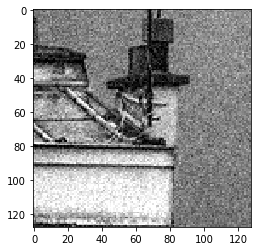

In [4]:
def snr(x, y):
    s =  np.linalg.norm(x - y)
    if s == 0:
        return "Equal inputs"
    return 20 * np.log10(np.linalg.norm(x) /s)
def clamp0(x):
    temp =  255*(x>255) + x * (x<255) 
    return temp * (x>0)
def clamp(x,a,b):
    temp = b*(x>b) + x * (x<b)  
    result = temp*(temp>a) + a*(x<a)
    return result
def GaussianNoise(image,sigma):
    return clamp0(image + sigma*np.random.randn(image.shape[0],image.shape[1]))

def SaltNoise(image,sigma):
    return clamp0(image + sigma*(np.random.randn(image.shape[0],image.shape[1])>0))

sigma = 20.0
noisy_image  = clamp0(image + sigma*np.random.randn(image.shape[0],image.shape[1]))
#noisy_image = denoised1
print(np.min(noisy_image))
plt.imshow(noisy_image)

In the cell below, we construct an array that codes for the coordinates of the patches.

In [5]:
half_taille_patch = 3
taille_patch = 2*half_taille_patch + 1
[X,Y,dX,dY] = np.meshgrid(np.arange(1,n+1),np.arange(1,n+1),np.arange(-half_taille_patch,half_taille_patch+1),np.arange(-half_taille_patch,half_taille_patch+1))
X = X + dX # x coordinate
Y = Y + dY # y coordinate
# hereafter we deal with the boundaries.
X[X < 1] = 2-X[X < 1] 
Y[Y < 1] = 2-Y[Y < 1]
X[X > n] = 2*n-X[X > n]
Y[Y > n] = 2*n-Y[Y > n]

We collect the patches below using $I$ which collects the coordinates defining the patches.

In [6]:
I = (X-1) + (Y-1)*n
print("size of the array I ",I.shape)
for i in range(n//half_taille_patch):
    for j in range(n//half_taille_patch):
        I[i,j] = np.transpose(I[i,j])
patch = lambda f: np.ravel(f)[I]
P = patch(image)

size of the array I  (128, 128, 7, 7)


## Q1. What happens for the patches on the boundary of the image for the patches ?

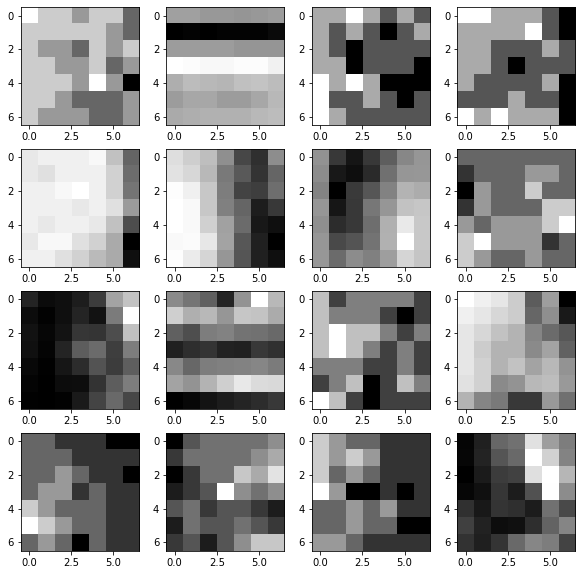

In [7]:
### some random patches.
plt.figure(figsize = (10,10))
for i in range(16):
    x = np.random.randint(n)
    y = np.random.randint(n)
    plt.subplot(4,4,i+1)
    plt.imshow(P[x, y])
plt.show()

## 2. Dimensionality reduction using PCA: Principal Component Analysis.

We have collected a large number of patches and we would like to represent this collection of patches by a simple known distribution that approximates it. The PCA method uses a gaussian approximation. Note that the size of a patch is $6^2$ or $8^2$, so that we want to reduce the dimension to $15$ or a bit more.
The PCA algorithm finds a linear subspace of dimension $k$, which is chosen by the user, that minimizes the distances of data with respect to this subspace.

In [8]:
dimension = 25
# a reshape function
resh = lambda P: np.transpose((np.reshape(P, (n*n,taille_patch**2), order="F")))
# remove mean is a preparation for PCA.
remove_mean = lambda Q: Q - np.tile(np.mean(Q,0),(taille_patch**2,1))
P1 = remove_mean(resh(P))
C = np.dot(P1,np.transpose(P1))

What is used below is a method in linear algebra called Singular Value Decomposition «SVD», and gives the subspaces being spanned by the first $k$ eigenvectors corresponding to the $k$ largest eigenvalues of the decomposition. 

In [9]:
[D,V] = np.linalg.eig(C)
# the array D is the list of eigenvalues and the arry V is the corresponding eigenvectors.
# We then sort the values in decreasing order and reindex the corresponding eigenvectors.
D = np.sort(D)[::-1]
I = np.argsort(D)[::-1]
V = V[I,:]

## Q2. 

1. Plot the decreasing eigenvalues and decide how many eigenvectors are representative of the distribution of the patches under this gaussian assumption. 
2. Check the L2 norm of the eigenvectors.
3. Plot the corresponding eigenvectors which represent the main modes of variation of the patches.

In [12]:
iresh = lambda Q: np.reshape(np.transpose(Q),(n,n,dimension),order="F")
H = iresh(np.dot(np.transpose(V[: ,:dimension]),remove_mean(resh(P))))
print(np.transpose(V[: ,:dimension]).shape,remove_mean(resh(P)).shape)
print(H.shape)

(25, 49) (49, 16384)
(128, 128, 25)


In [13]:
# Create the gaussian kernel on patches
distance = lambda i: np.sum((H - np.tile(H[i[0],i[1],:], (n,n,1)))**2, 2)/(taille_patch**2)
normalize = lambda K: K/np.sum(K)
kernel = lambda i,tau: normalize(np.exp(-distance(i)/(2*tau**2)))

In [14]:
# Some parameters and an example
tau = 10.0
i = [60,20]
D = distance(i)
K = kernel(i, tau)

### Q3. Explain what is shown below ?

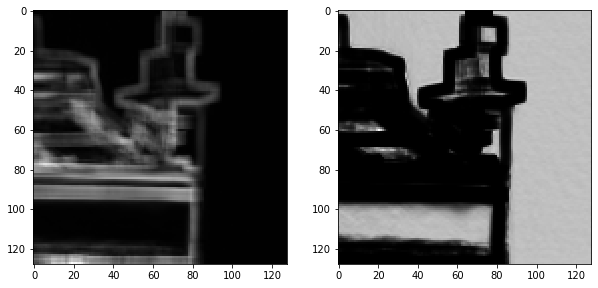

In [15]:
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.imshow(D)
plt.subplot(1,2,2)
plt.imshow(K)
plt.show()

In [16]:
# Selection of the parameter that select a range of patches in order to fasten the computations so in fact 
# the algorithm is a bit more local...
q = 14

In [17]:
selection = lambda i: np.array((clamp(np.arange(i[0]-q,i[0] + q + 1), 0, n-1), clamp(np.arange(i[1]-q,i[1] + q + 1), 0, n-1)))

In [18]:
def distance_0(i,sel): 
    H1 = (H[sel[0],:,:])
    H2 = (H1[:,sel[1],:])
    return np.sum((H2 - np.tile(H[i[0],i[1],:],(len(sel[0]),len(sel[1]),1)))**2,2)/(taille_patch**2)

distance = lambda i: distance_0(i, selection(i))
kernel = lambda i, tau: normalize(np.exp(-distance(i)/ (2*tau**2)))

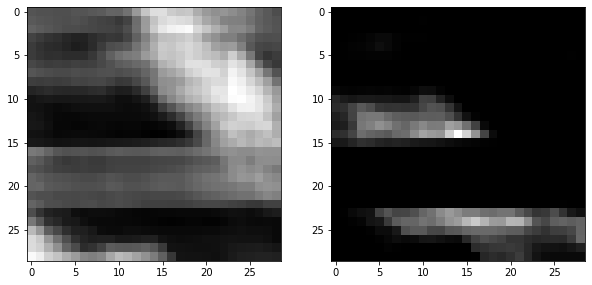

In [19]:
D = distance(i)
K = kernel(i, tau)
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.imshow(D)
plt.subplot(1,2,2)
plt.imshow(K)
plt.show()

In [20]:
def NLval_0(K,sel): 
    f_temp = noisy_image[sel[0],:]
    return np.sum(K*f_temp[:, sel[1]])

NLval = lambda i, tau: NLval_0(kernel(i, tau), selection(i))

### Q4. Understand the code below.

In [21]:
[Y, X] = np.meshgrid(np.arange(0,n),np.arange(0,n))

def arrayfun(img,X,Y):
    n = len(X)
    p = len(Y)
    R = np.zeros([n,p])
    for k in range(n):
        for l in range(p):
            R[k,l] = img(k,l)
    return R

NLmeans = lambda tau: arrayfun(lambda i1, i2: NLval([i1,i2], tau), X, Y)

### Q5. Find the optimal parameters for denoising the image to obtain the highest possible SNR. 

### Q6. Compare with cycle spinning wavelet denoiser.